## Random Forests

In this tutorial, we will apply random forest regression model on a set of features to predict maximum temperature on a current day. Our example dataset is obtained from NOAA (https://www.noaa.gov/) and contained one year recording of daily temperatures at Seattle in 2016.

This Jupyter notebook is taken from Will Koehrsen's tutorial on Random Forests at towardsdatascience - https://towardsdatascience.com/random-forest-in-python-24d0893d51c0. Check out his other tutorials about Random Forests! He is an awesome teacher and data scientist!

### First we will download the data

In [1]:
import wget
wget.download("https://docs.google.com/uc?export=download&id=1pko9oRmCllAxipZoa3aoztGZfPAD2iwj")

'temps (1).csv'

### Exploring the data

In [2]:
# Pandas is used for data manipulation
import pandas as pd
# Read in data and display first 5 rows
features = pd.read_csv('temps.csv')
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


* **Temp_2** : Maximum temperature on 2 days prior to today. 
* **Temp_1**: Maximum temperature on yesterday. 
* **Average**: Historical temperature average 
* **Actual**: Actual measure temperature on today. 
* **Forecast_NOAA**: Temperature values forecasted by NOAA
* **Friend**: Forecasted by Friend (Randomly selected number within plus-minus 20 of Average temperature)

In [3]:
print('The shape of our features is:', features.shape)

The shape of our features is: (348, 12)


In [4]:
# Descriptive statistics for each column
features.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


In [5]:
# Use datetime for dealing with dates
import datetime

# Get years, months, and days
years = features['year']
months = features['month']
days = features['day']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')


## Quality Check

Identifying anomalous patterns by visually observing their plots

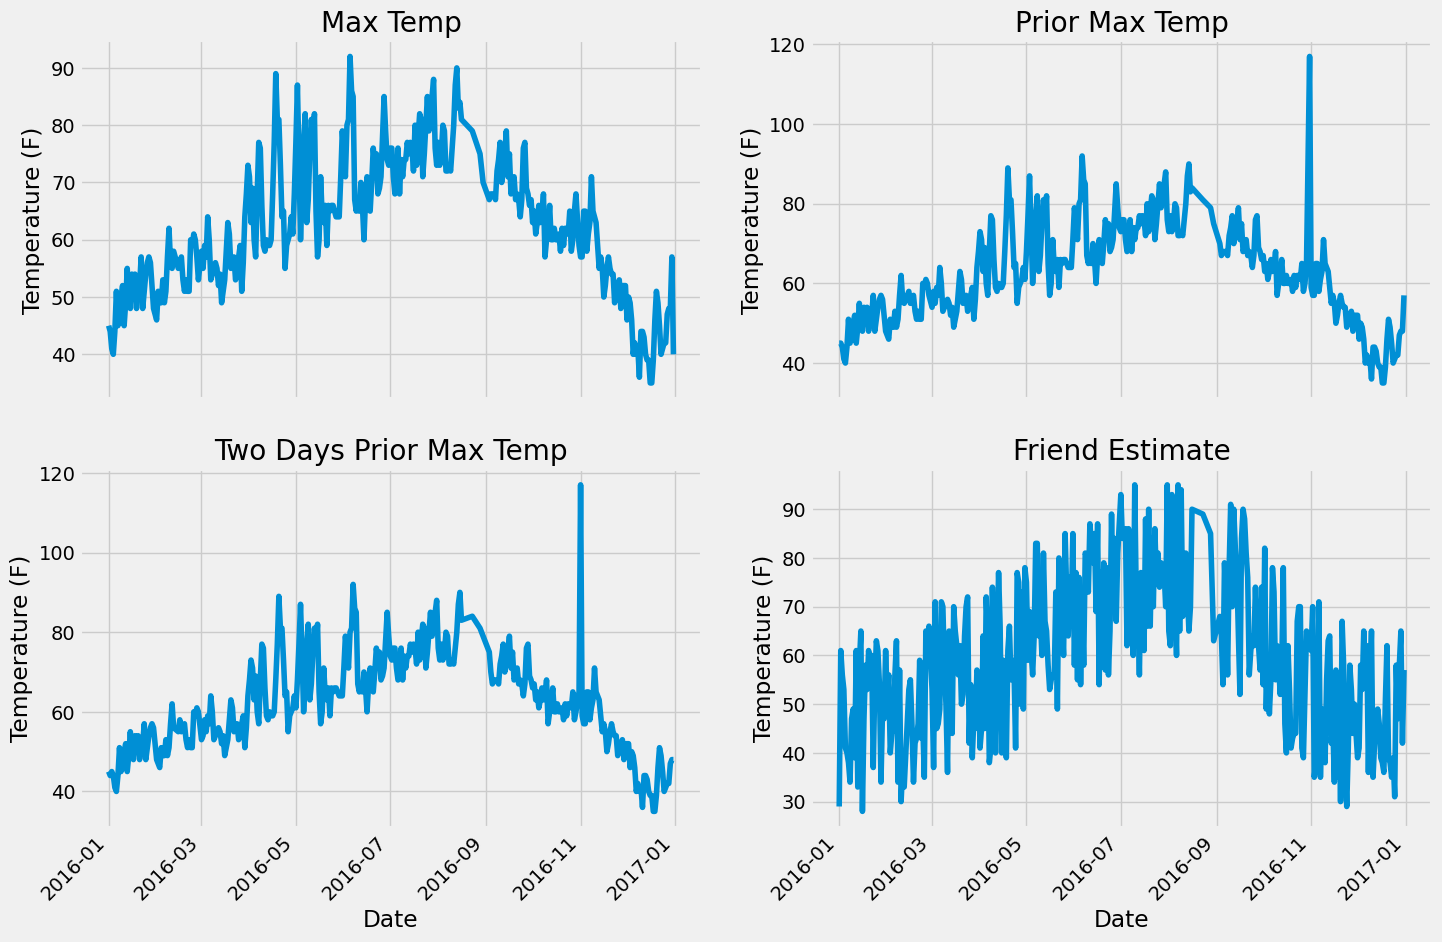

In [6]:
# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
fig.autofmt_xdate(rotation = 45)

# Actual max temperature measurement
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature (F)'); ax1.set_title('Max Temp')

# Temperature from 1 day ago
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature (F)'); ax2.set_title('Prior Max Temp')

# Temperature from 2 days ago
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature (F)'); ax3.set_title('Two Days Prior Max Temp')

# Friend Estimate
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature (F)'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)


## Data Preparation

##### 1. One-Hot Encoding


One-hot encoding is used to convert categorical values to numerical values. If the data was labeled from 1 to 7 for the days of the week, it would artifically assign greater importance to Sunday.

In [ ]:
# One-hot encode the data using pandas get_dummies
features = pd.get_dummies(features)
# Display the first 5 rows of the last 12 columns
features.iloc[:,5:].head(5)

#### 2. Separating Features and Labels

labels in this case are the actual values of temperature

In [ ]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we want to predict
labels = np.array(features['actual'])
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('actual', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

#### 3. Splitting the data randomly into Test and Training sets

random_state = 42 ensure the similarity of the split in each iteration

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

#### 4. Setting up the model baseline

In [ ]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('average')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

#### 5. Initializing a random forest regression model

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

#### 6. Assesing the performance of a model 

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#### 7. Computing the Feature Importances

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('temp_1'), feature_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [ ]:
# Use datetime for creating date objects for plotting
import datetime
# Dates of training values
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]
# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})
# Dates of predictions
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]
# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = 60); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

In [ ]:
# Make the data accessible for plotting
true_data['temp_1'] = features[:, feature_list.index('temp_1')]
true_data['average'] = features[:, feature_list.index('average')]
true_data['friend'] = features[:, feature_list.index('friend')]
# Plot all the data as lines
plt.plot(true_data['date'], true_data['actual'], 'b-', label  = 'actual', alpha = 1.0)
plt.plot(true_data['date'], true_data['temp_1'], 'y-', label  = 'temp_1', alpha = 1.0)
plt.plot(true_data['date'], true_data['average'], 'k-', label = 'average', alpha = 0.8)
plt.plot(true_data['date'], true_data['friend'], 'r-', label = 'friend', alpha = 0.3)
# Formatting plot
plt.legend(); plt.xticks(rotation = 60);
# Lables and title
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual Max Temp and Variables');